In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))


In [3]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Database
from db import PostgresDB
from schemas import Proband
from cohorts import Cohort

# Clustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

# Plotting matrix
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from plotting import plot_endpoints_for_clusters
sns.color_palette()



[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [4]:
load_dotenv()


True

In [5]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
)


Connected to database


In [9]:
# format is: [(hadm_id_a, hadm_id_b, demographic, icd, lab, vital, input)]
similarity_values = db.get_all_similarity_values()


In [10]:
def get_sim_value(
    input_tuple: tuple,
    demo_weight,
    icd_weight,
    lab_weight,
    vitals_weight,
    input_weight,
    aggregate,
):
    """Input tuple is (hadm_id_a, hadm_id_b, demographic, icd, lab, vital, input)"""
    demo_value = input_tuple[2]
    icd_value = input_tuple[3]
    lab_value = input_tuple[4]
    vitals_value = input_tuple[5]
    input_value = input_tuple[6]

    if aggregate == "mean":
        similarity_value = (
            demo_weight * demo_value
            + icd_weight * icd_value
            + lab_weight * lab_value
            + vitals_weight * vitals_value
            + input_weight * input_value
        )
    return similarity_value


def create_similarity_matrix(
    similarity_list,
    demo_weight=0.1,
    icd_weight=0.1,
    lab_weight=0.6,
    vitals_weight=0.1,
    input_weight=0.1,
    aggregate="mean",
):
    # Get a list of all patient IDs
    patient_ids = list(
        set([t[0] for t in similarity_list] + [t[1] for t in similarity_list])
    )
    patient_ids.sort()

    # Create an empty matrix with NaN values
    similarity_matrix = pd.DataFrame(index=patient_ids, columns=patient_ids)
    similarity_matrix = similarity_matrix.fillna(float(1.0))

    # calculate the similarity value
    # Fill in the similarity values
    for t in similarity_list:
        sim_value = get_sim_value(
            t,
            demo_weight,
            icd_weight,
            lab_weight,
            vitals_weight,
            input_weight,
            aggregate,
        )
        similarity_matrix.at[t[0], t[1]] = sim_value
        similarity_matrix.at[t[1], t[0]] = sim_value

    return similarity_matrix


In [11]:
# PARAMETERS

# SIMILARITY SCORE
DEMO_WEIGHT = 0.05
ICD_WEIGHT = 0.30
LAB_WEIGHT = 0.40
VITALS_WEIGHT = 0.20
INPUT_WEIGHT = 0.05
AGGREGATE = "mean"

# CLUSTERING
N_CLUSTERS = 4
N_COMPONENTS = 2


In [12]:
df = create_similarity_matrix(
    similarity_values,
    demo_weight=DEMO_WEIGHT,
    icd_weight=ICD_WEIGHT,
    lab_weight=LAB_WEIGHT,
    vitals_weight=VITALS_WEIGHT,
    input_weight=INPUT_WEIGHT,
    aggregate=AGGREGATE,
)


KeyboardInterrupt: 

<Axes: >

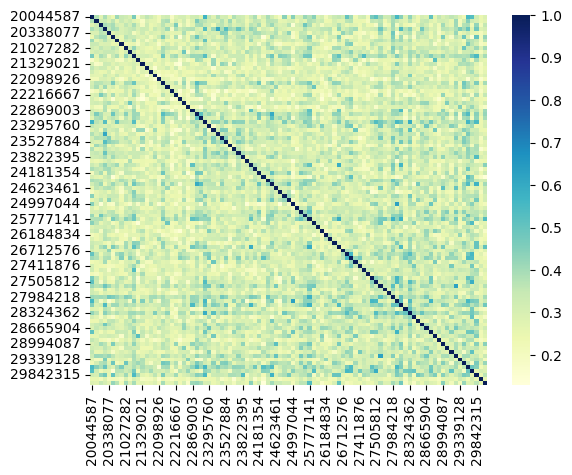

In [27]:
sns.heatmap(df, cmap="YlGnBu", fmt=".2f")


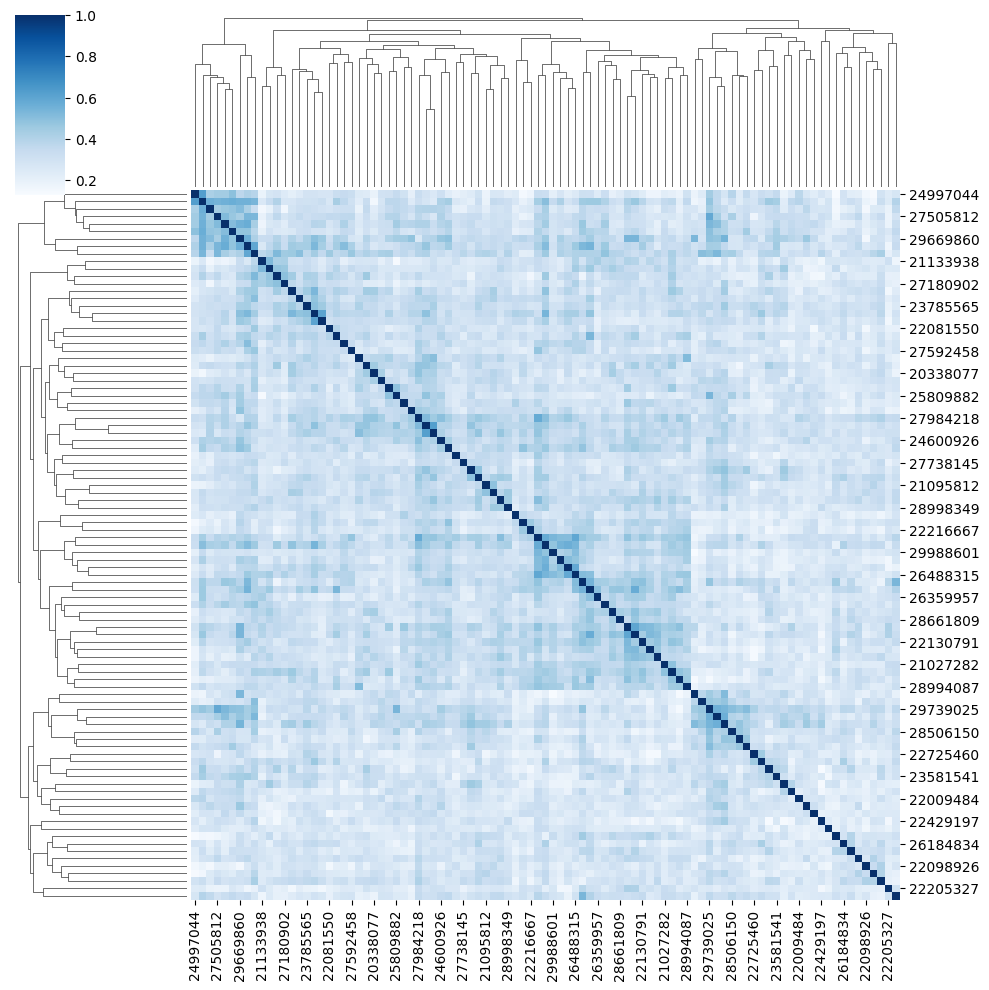

In [28]:
sns.clustermap(df, annot=False, fmt=".2f", cmap="Blues")


In [29]:
spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(df)
agglomerative_cluster = AgglomerativeClustering(
    n_clusters=N_CLUSTERS, metric="precomputed", linkage="average"
).fit(df)
kmeans_cluster = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(df)
dbscan_cluster = DBSCAN(eps=0.5, min_samples=2).fit(df)
affinity_cluster = AffinityPropagation().fit(df)

clusters = [
    spectral_cluster,
    agglomerative_cluster,
    kmeans_cluster,
    dbscan_cluster,
    affinity_cluster,
]


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

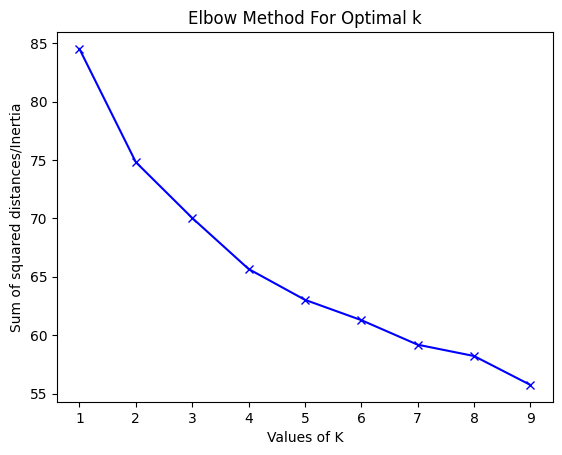

In [30]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
def plot_cluster(df, cluster, method):
    if method == "mds":
        mds = MDS(
            n_components=N_COMPONENTS, dissimilarity="precomputed", random_state=1
        )
        pos = mds.fit_transform(df)
    elif method == "pca":
        pca = PCA(n_components=N_COMPONENTS)
        pos = pca.fit_transform(df)
    elif method == "tsne":
        tsne = TSNE(n_components=N_COMPONENTS)
        pos = tsne.fit_transform(df)
    else:
        print("Invalid method")
        return
    sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=cluster.labels_, cmap="").set_title(
        f"{cluster.__class__.__name__}, {method.upper()}"
    )


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


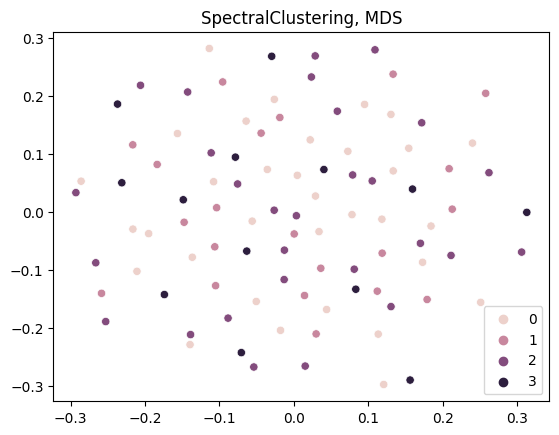

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


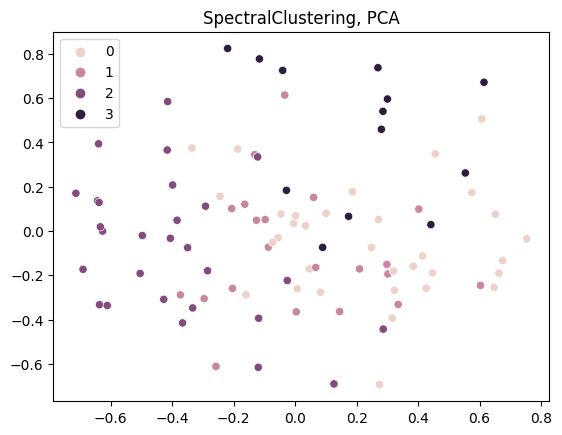

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


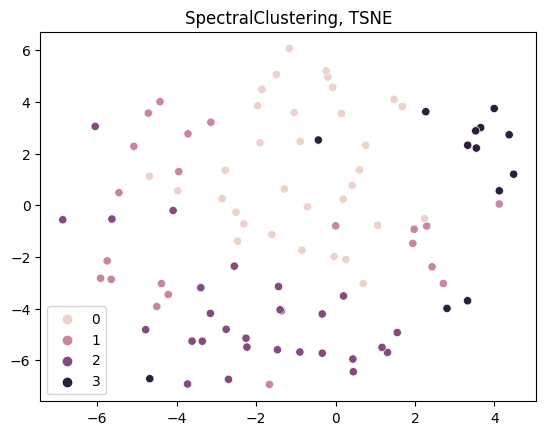

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


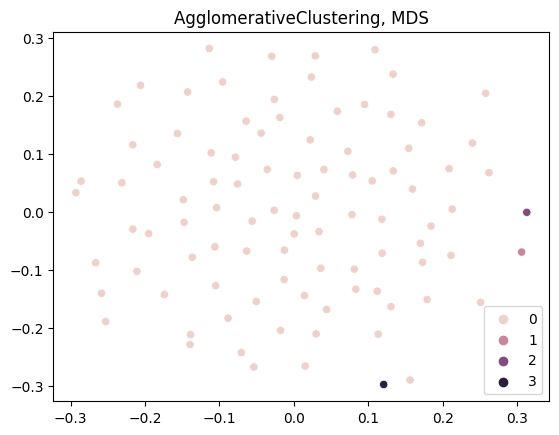

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


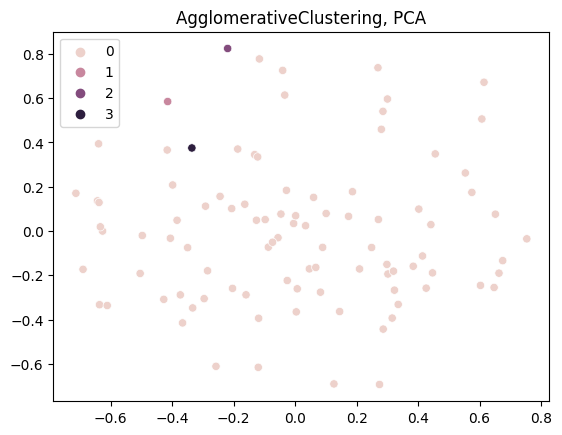

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


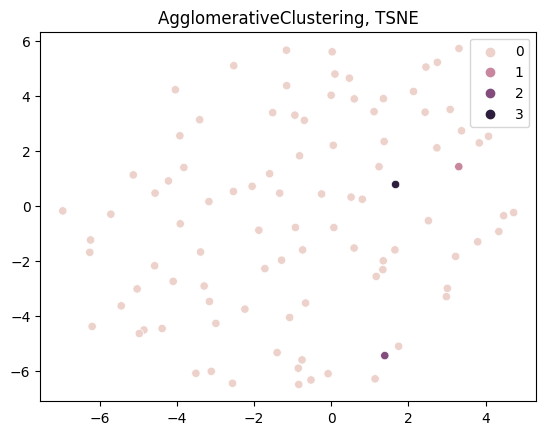

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


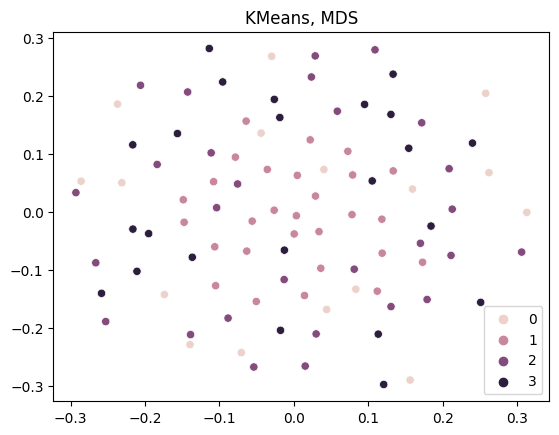

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


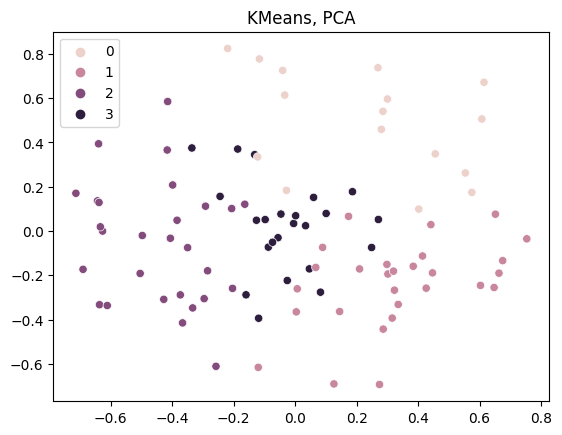

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


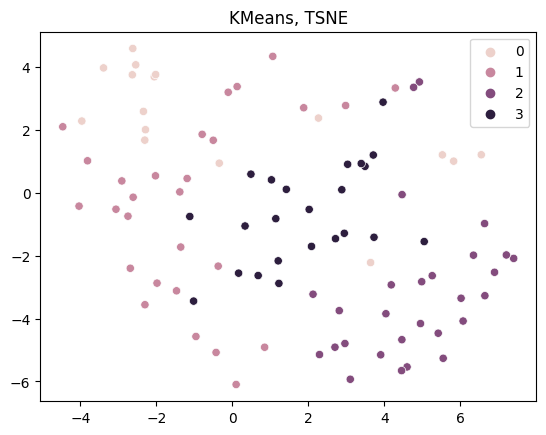

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


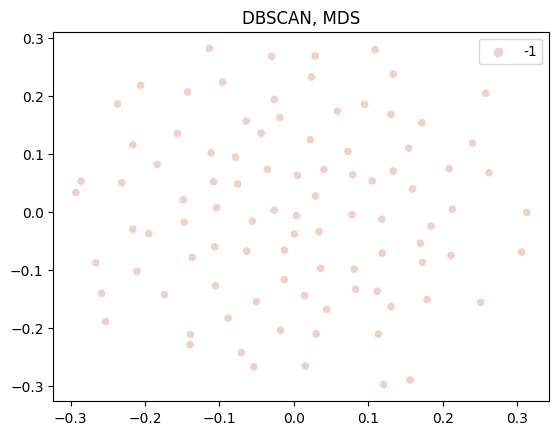

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


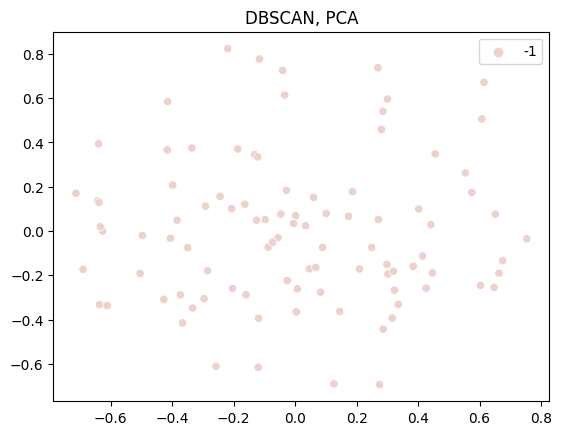

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


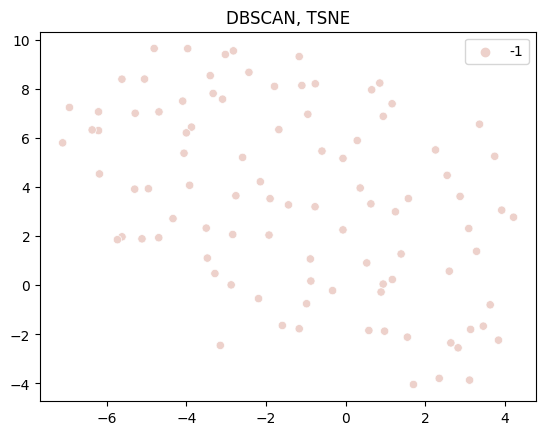

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


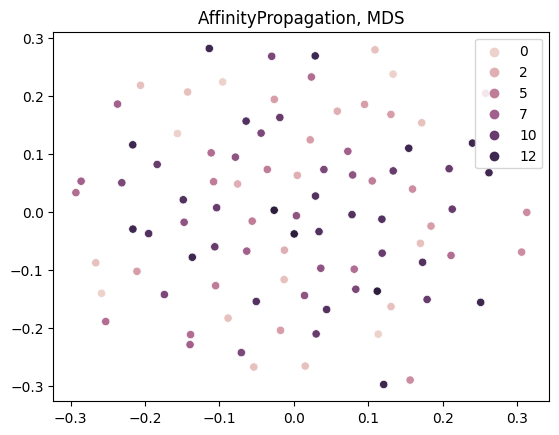

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


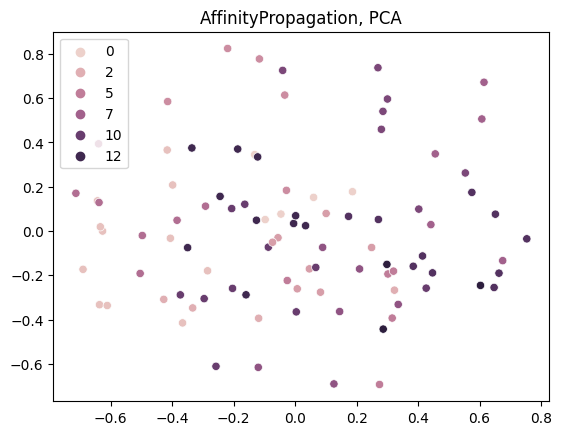

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


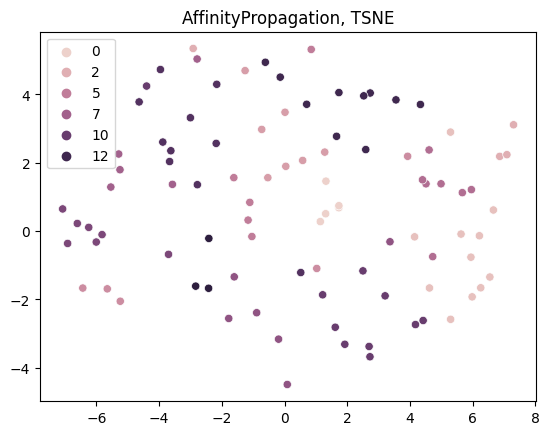

In [32]:
for cluster in clusters:
    for method in ["mds", "pca", "tsne"]:
        plot_cluster(df, cluster, method)
        plt.show()

In [33]:
participants = [Proband(hadm_id=i) for i in df.columns]
for p in participants:
    los_icu, los_hosp = db.get_endpoints_for_hadm_id(p.hadm_id)
    p.los_icu = los_icu
    p.los_hosp = los_hosp


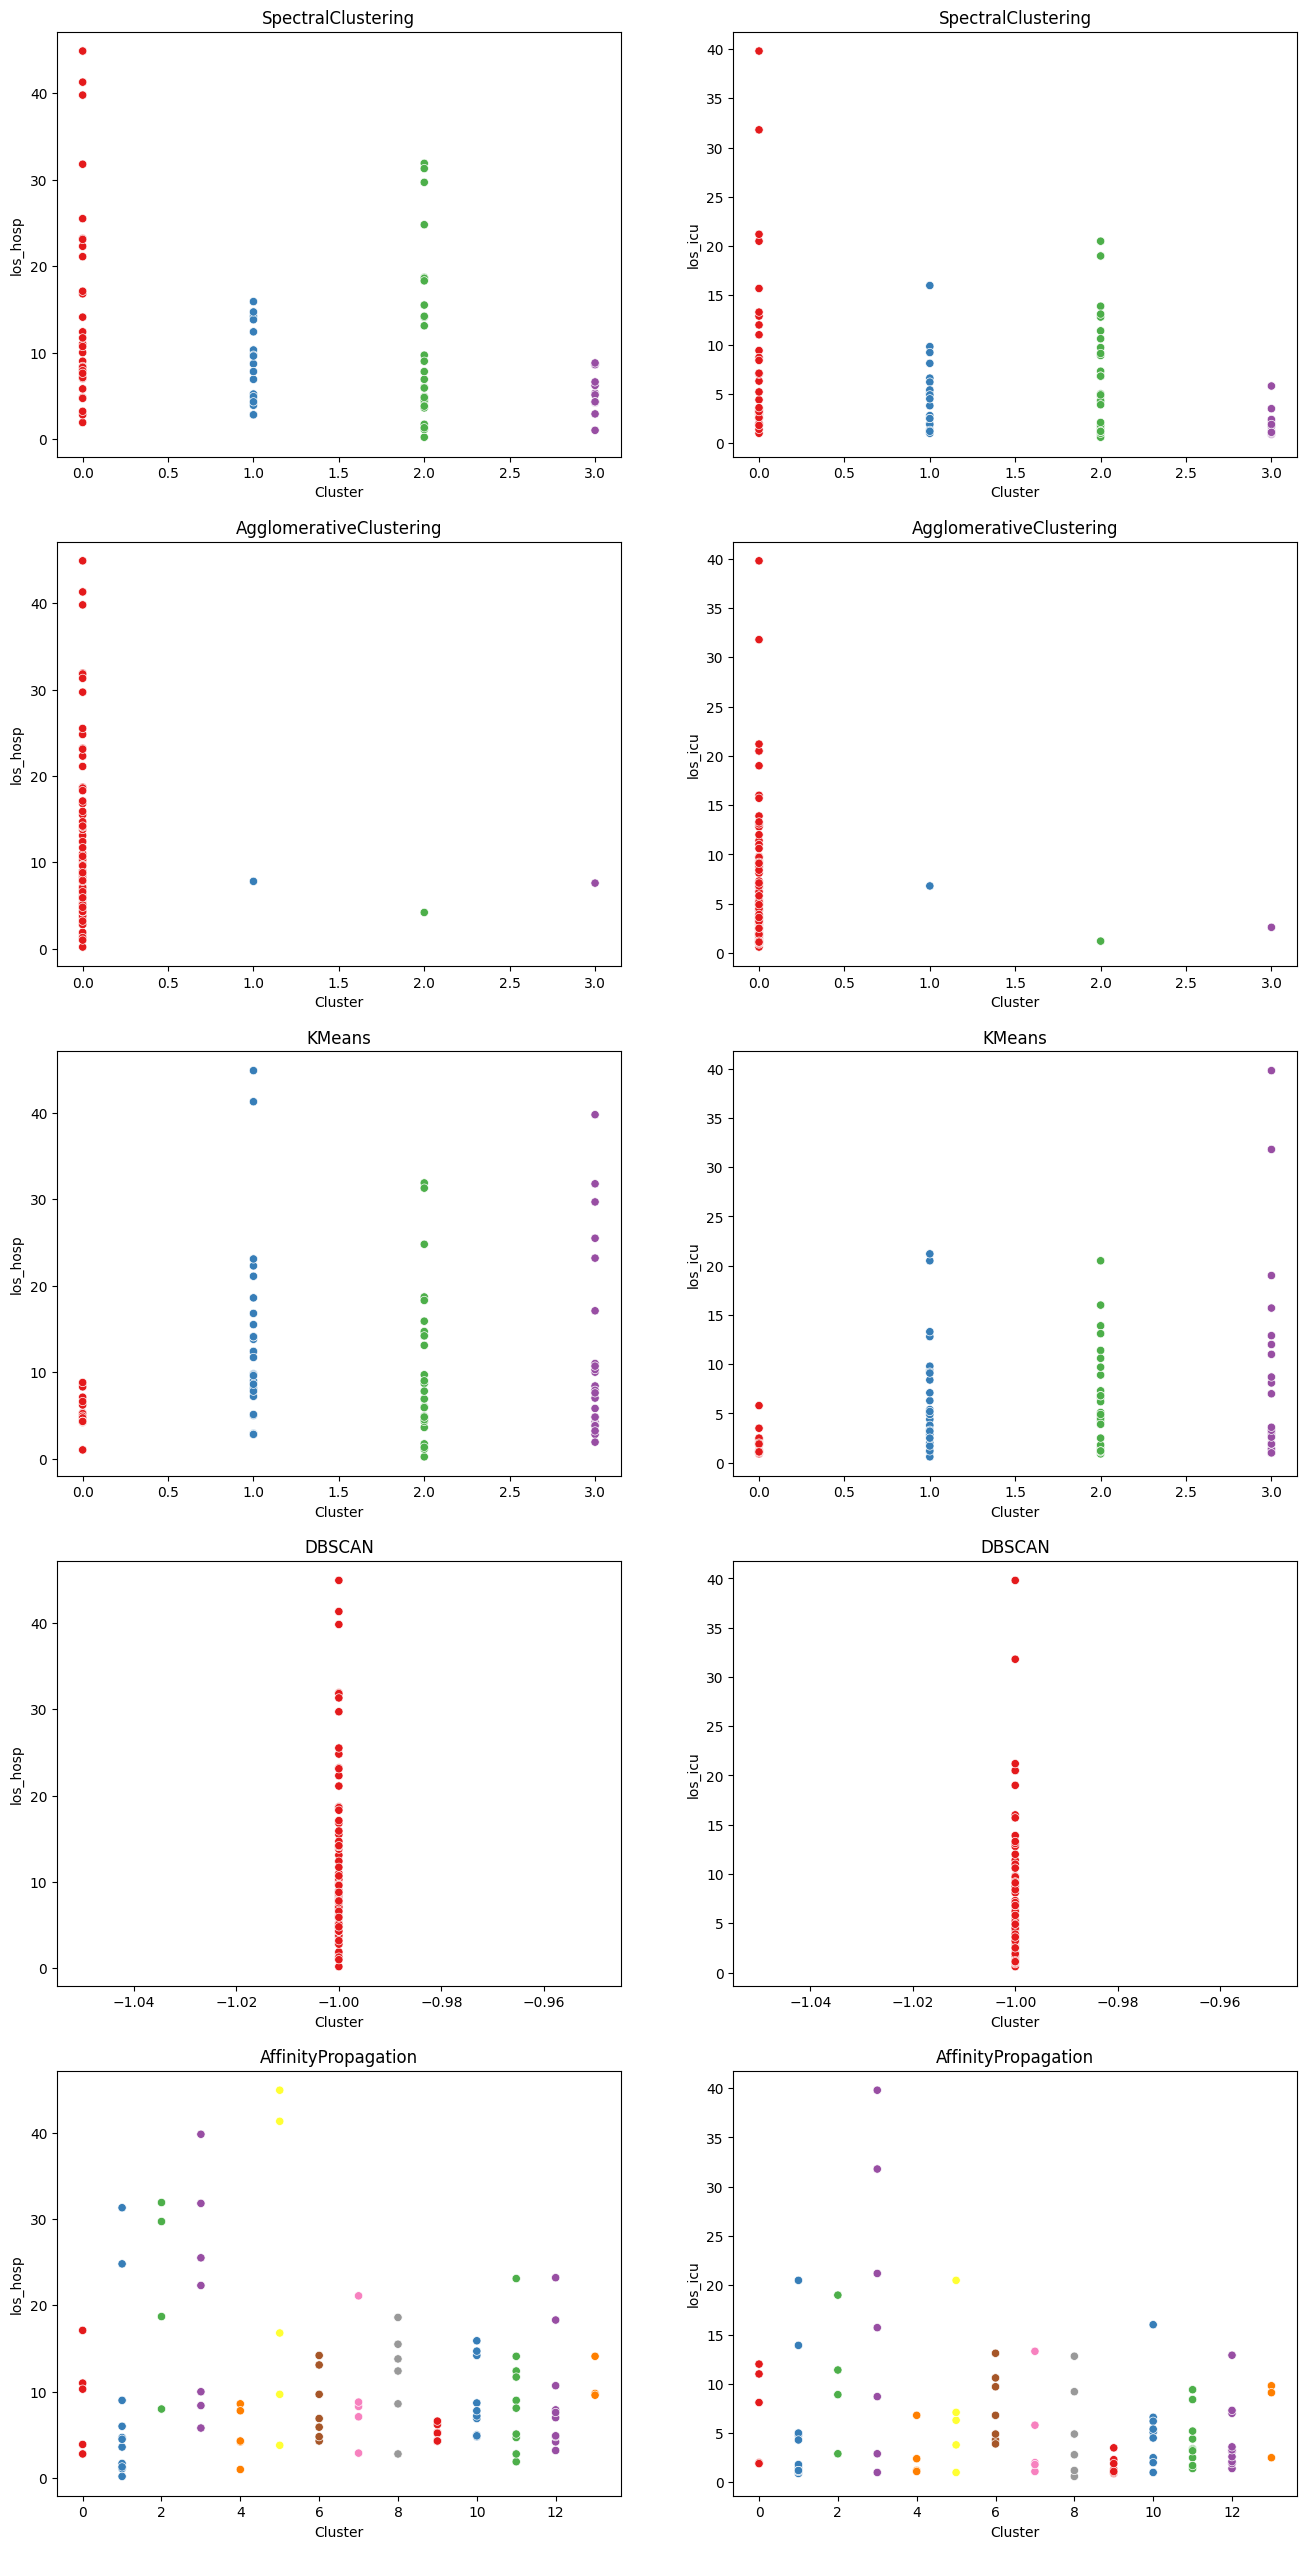

In [34]:
plot_endpoints_for_clusters(participants, clusters)
